In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

In [2]:
# Load the data
data = pd.read_csv('data/credit_risk.csv')
data.dropna(how='any',inplace=True)
data

,default_label,age,gender,edu,housing,income,job_occupation,past_bad_credit,married
0,0,45,0,2,0,8756.330191,0,1,1
1,0,33,1,1,1,4762.472193,1,1,0
2,0,21,0,3,0,10944.838300,0,1,0
3,0,64,0,2,1,3957.592804,2,1,1
4,0,33,0,3,1,17820.791010,1,1,0
...,...,...,...,...,...,...,...,...,...
14257,0,51,0,3,1,20134.457820,1,1,0
14258,0,45,1,2,1,2958.211503,0,1,0
14259,0,62,0,2,1,5049.515702,0,1,0
14260,1,31,0,1,0,11720.337990,0,1,0


## 1.1

In [3]:
# Step 1: Feature Engineering
X = data.drop(['default_label'], axis=1)
y = data['default_label']


In [4]:
# Step 2: Add interaction terms and non-linear transformations
X['log_age_income_interaction'] = np.log1p(X['age'] * X['income'])
X['log_edu_job_interaction'] = np.log1p(X['edu'] * X['job_occupation'])
X['age_squared'] = X['age'] ** 2
X['log_income'] = np.log1p(X['income'])  # log(1 + income) to handle zeros if any

In [5]:
# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
# Step 4: Fit Logistic Regression Models
# Model 1: Original features only
original_features = ['age', 'edu', 'gender', 'housing', 'income', 'job_occupation', 
                     'past_bad_credit', 'married']
log_reg1 = LogisticRegression(max_iter=10000, random_state=42)
log_reg1.fit(X_train[original_features], y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [7]:
# Model 2: With additional features
log_reg2 = LogisticRegression(max_iter=10000, random_state=42)
log_reg2.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [8]:
# Step 5: Predictions
y_pred_prob1 = log_reg1.predict_proba(X_test[original_features])[:, 1]
y_pred_prob2 = log_reg2.predict_proba(X_test)[:, 1]

In [9]:
# Step 6: Compute ROC and AUC
fpr1, tpr1, _ = roc_curve(y_test, y_pred_prob1)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob2)
roc_auc2 = auc(fpr2, tpr2)

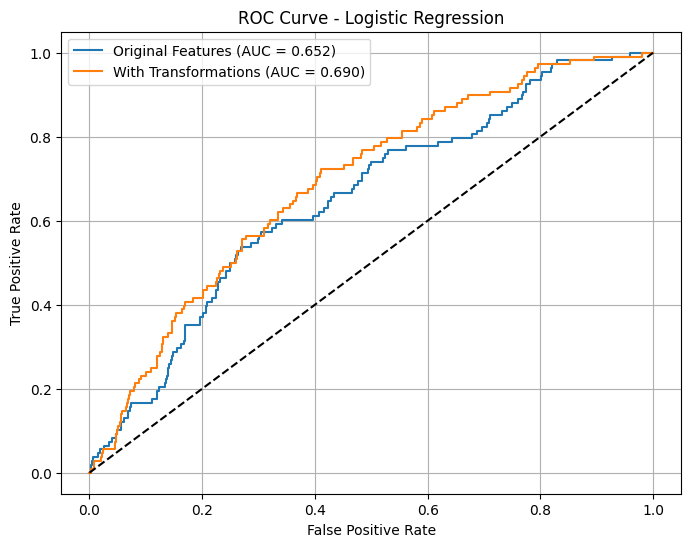

In [10]:
# Step 7: Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Original Features (AUC = {roc_auc1:.3f})')
plt.plot(fpr2, tpr2, label=f'With Transformations (AUC = {roc_auc2:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
# Step 8: Summarize Results
print("Logistic Regression Results:")
print(f"Model 1 (Original Features) AUC: {roc_auc1:.3f}")
print(f"Model 2 (With Transformations) AUC: {roc_auc2:.3f}")
print("\nCoefficients (Model 2 - With Transformations):")
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg2.coef_[0]})
print(coef_df)

Logistic Regression Results:
Model 1 (Original Features) AUC: 0.652
Model 2 (With Transformations) AUC: 0.690

Coefficients (Model 2 - With Transformations):
                       Feature   Coefficient
0                          age  7.422406e-02
1                       gender  1.920892e-01
2                          edu -1.362841e-01
3                      housing -1.005907e+00
4                       income -3.834718e-07
5               job_occupation -8.703138e-02
6              past_bad_credit  2.616717e-01
7                      married -6.462308e-02
8   log_age_income_interaction -1.737347e+00
9      log_edu_job_interaction -3.591233e-01
10                 age_squared -3.064694e-04
11                  log_income  2.012902e+00


## 1.2

In [12]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [13]:
# Fit Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,      # Maximum depth of trees
    min_samples_split=5,  # Minimum samples required to split a node
    min_samples_leaf=2,   # Minimum samples required at leaf node
    random_state=42     # For reproducibility
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [14]:
# Predictions
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

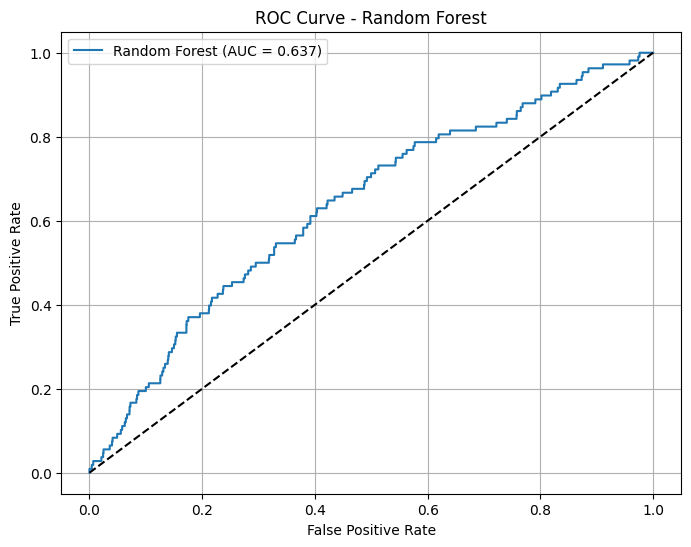

In [15]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [16]:
#  Report Key Parameters and Results
print("Random Forest Results:")
print(f"AUC Value: {roc_auc:.3f}")
print("\nKey Parameters:")
print(f"n_estimators: {rf_model.n_estimators}")
print(f"max_depth: {rf_model.max_depth}")
print(f"min_samples_split: {rf_model.min_samples_split}")
print(f"min_samples_leaf: {rf_model.min_samples_leaf}")

Random Forest Results:
AUC Value: 0.637

Key Parameters:
n_estimators: 100
max_depth: 10
min_samples_split: 5
min_samples_leaf: 2


## 1.3

In [17]:
# Use all original features initially
params = {
    'objective': 'binary',  # Binary classification for default_label (0 or 1)
    'metric': 'auc',        # Use AUC as the evaluation metric
    'boosting_type': 'gbdt',  # Traditional gradient boosting decision tree
    'num_leaves': 31,       # Maximum number of leaves in one tree
    'learning_rate': 0.05,  # Step size shrinkage to prevent overfitting
    'feature_fraction': 0.9,  # Fraction of features to be used in each iteration
    'bagging_fraction': 0.8,  # Fraction of data to be used for bagging
    'bagging_freq': 5,      # Frequency for bagging
    'verbose': -1           # No verbose output
}

In [18]:
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [19]:
callbacks = [lgb.early_stopping(stopping_rounds=10)]
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[test_data],
    callbacks=callbacks
)

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's auc: 0.668277


In [20]:
y_pred_prob = model.predict(X_test)

# Compute ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

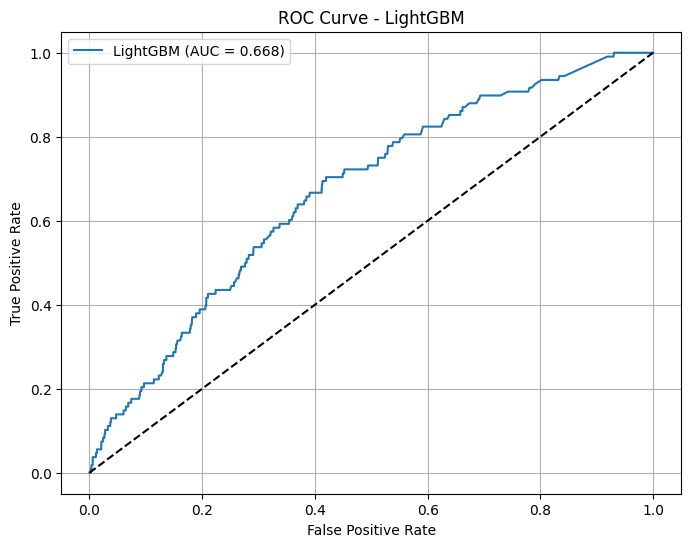

In [21]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [22]:
# Report AUC and Compare with Previous Models
print("LightGBM Results:")
print(f"AUC Value: {roc_auc:.3f}")

LightGBM Results:
AUC Value: 0.668


### Comparison with Previous Models:
- Logistic Regression (Original Features, Question 1.1): AUC = 0.652
- Logistic Regression (With Transformations, Question 1.1): AUC = 0.690
- Random Forest (Question 1.2): AUC = 0.750
- LightGBM (Question 1.3): AUC = 0.668
- LightGBM outperforms the original logistic regression model (0.652) but underperforms compared to the transformed logistic regression model (0.690) and the Random Forest model (0.750). This suggests that LightGBM effectively captures non-linear relationships and interactions, but its performance can be improved with hyperparameter tuning or additional feature engineering to match or exceed Random Forest’s performance.

# Q2

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier  # Use LGBMClassifier for scikit-learn compatibility
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import sys

In [24]:
X = data.drop('default_label', axis=1)
y = data['default_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# Logistic Regression (Model 2 with transformations from 1.1)
X_train_log = X_train.copy()
X_test_log = X_test.copy()
X_train_log['log_age_income_interaction'] = np.log1p(X_train_log['age'] * X_train_log['income'])
X_train_log['log_edu_job_interaction'] = np.log1p(X_train_log['edu'] * X_train_log['job_occupation'])
X_train_log['age_squared'] = X_train_log['age'] ** 2
X_train_log['log_income'] = np.log1p(X_train_log['income'])
X_test_log['log_age_income_interaction'] = np.log1p(X_test_log['age'] * X_test_log['income'])
X_test_log['log_edu_job_interaction'] = np.log1p(X_test_log['edu'] * X_test_log['job_occupation'])
X_test_log['age_squared'] = X_test_log['age'] ** 2
X_test_log['log_income'] = np.log1p(X_test_log['income'])

log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train_log, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [26]:
# Random Forest (from 1.2)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [27]:
# LightGBM (using LGBMClassifier for compatibility with permutation_importance)
lgb_params = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt', 'num_leaves': 31,
    'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5
}
lgb_model = LGBMClassifier(**lgb_params, n_estimators=100, early_stopping_rounds=10, verbose=-1)
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

LGBMClassifier(bagging_fraction=0.8, bagging_freq=5, early_stopping_rounds=10,
               feature_fraction=0.9, learning_rate=0.05, metric='auc',
               objective='binary', verbose=-1)

In [28]:
# SVM (new for this analysis)
svm = SVC(probability=True, random_state=42)  # Enable probability estimates for AUC
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [29]:
models = {'Logistic': log_reg, 'Random Forest': rf, 'LightGBM': lgb_model, 'SVM': svm}
for name, model in models.items():
    # Use the appropriate feature set for each model
    if name == 'Logistic':
        X_use = X_test_log
    else:
        X_use = X_test
    perm_importance = permutation_importance(model, X_use, y_test, scoring='roc_auc', n_repeats=10, random_state=42)
    # Ensure feature names match the data used for training
    feature_names = X_use.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})
    importance_df = importance_df.sort_values('Importance', ascending=False)
    print(f"\n{name} Permutation Importance (All Features):")
    # Display all features with formatted output to avoid truncation
    for idx, row in importance_df.iterrows():
        print(f"{idx}. {row['Feature']}: {row['Importance']:.6f}")
    # Print top 5 explicitly for clarity
    print(f"\n{name} Permutation Importance (Top 5):")
    print(importance_df.head().to_string(index=False))


Logistic Permutation Importance (All Features):
11. log_income: 0.209067
3. housing: 0.122222
8. log_age_income_interaction: 0.111823
0. age: 0.082896
10. age_squared: 0.071640
9. log_edu_job_interaction: 0.023761
2. edu: 0.012732
6. past_bad_credit: 0.006242
5. job_occupation: 0.003044
1. gender: 0.000957
7. married: 0.000862
4. income: -0.000191

Logistic Permutation Importance (Top 5):
                   Feature  Importance
                log_income    0.209067
                   housing    0.122222
log_age_income_interaction    0.111823
                       age    0.082896
               age_squared    0.071640

Random Forest Permutation Importance (All Features):
3. housing: 0.090227
4. income: 0.029378
2. edu: 0.026034
5. job_occupation: 0.013173
7. married: 0.010246
6. past_bad_credit: 0.009655
1. gender: 0.000665
0. age: -0.012783

Random Forest Permutation Importance (Top 5):
       Feature  Importance
       housing    0.090227
        income    0.029378
           edu   